In [22]:
# Подключение и монтирование диска в GoogleColab
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir("/content/drive/My Drive/Signature")
# !pip install tensorflow-gpu

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3992334600672622646
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14559321146970403947
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3301122014879602233
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4852561965185699479
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [33]:
# Импорт необходимых библиотек 
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
import PIL
import matplotlib.pyplot as plt
import numpy as np


In [34]:
# Глобальные переменные 
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'
img_width = 200
img_height = 100
input_shape = (img_height,img_width,3)
batch_size = 20
target_size =  (img_height,img_width)

In [35]:
from keras.applications import VGG16
conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = input_shape)

In [36]:
model = models.Sequential()
model.add(conv_base)
# До бавление нового классификатора
model.add(layers.Flatten())
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dense(50,activation='softmax'))
# Фиксирование свёрточной основы
conv_base.trainable= False 


In [37]:
# Компиляция модели
model.compile(optimizer='rmsprop', # Алгоритм обратного распространения ошибки
             loss='categorical_crossentropy', # Функция потерь - перекрестная энтропия
             metrics = ['accuracy'])

In [38]:
# Функция предобработки
def function(image):
  #отсечение фона
  image[:][np.mean(image[:][:],axis=2)>240] = 255
  return image

In [39]:
# Датагены для обучения и проверки 
train_datagen = ImageDataGenerator(
                                  rescale=1. / 255, # Масштабирование
                                  rotation_range = 5, # Поворот
                                  zoom_range=[1.3, 1.4],                                                                   
                                  width_shift_range= [0,20], # Сдвиг по горизонтали 
                                  height_shift_range= [0,10], # Сдвиг по вертикали 
                                  preprocessing_function = function, # Функция предобработки
                                  cval = 255.0, # Значения заполнения
                                  fill_mode = 'constant' # Метод заполнения
                                   )
test_datagen = ImageDataGenerator(
                                  rescale=1. / 255,  
                                  zoom_range=[1.35, 1.35],
                                  preprocessing_function = function,
                                  cval = 255.0,
                                  fill_mode = 'constant'
                                   )

In [40]:
# Генераторы для обученя, проверки, и тестирования
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size = target_size,
    batch_size = batch_size,
    class_mode='categorical') 

val_generator = test_datagen.flow_from_directory( 
    val_dir,
    target_size = target_size,
    batch_size = batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = target_size,
    batch_size = batch_size,
    class_mode='categorical',
    )

Found 519 images belonging to 50 classes.
Found 100 images belonging to 50 classes.
Found 100 images belonging to 50 classes.


In [ ]:
# Метод для преждевременной остановки обучения
from  keras.callbacks import Callback
class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='accuracy', value=1.00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
    def on_epoch_end(self, epoch, logs={}):
      current = logs.get(self.monitor)
      if current is None:
          warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

      if current >= self.value:
          if self.verbose > 0:
              print("Epoch %05d: early stopping THR" % epoch)
          self.model.stop_training = True

# Обучение модели
from PIL import  Image
import keras.callbacks
history = model.fit_generator(
    train_generator,
    callbacks = [ EarlyStoppingByAccuracy(monitor='val_accuracy', value=1.1, verbose=4)],
    steps_per_epoch = 500 // batch_size,
    epochs=20,
    validation_data= val_generator,
    validation_steps = 5)

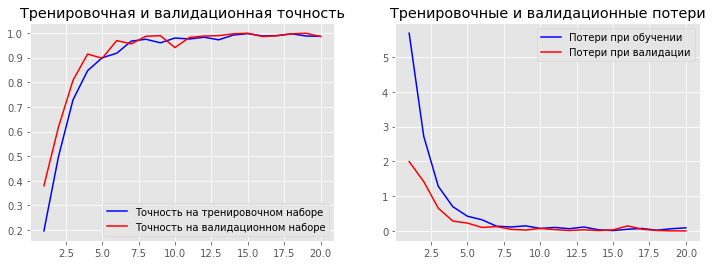

In [43]:
# Графики процесса обучения
def smooth_curve(points, factor=0.3):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, smooth_curve(acc), 'b', label='Точность на тренировочном наборе')
    plt.plot(x, smooth_curve(val_acc), 'r', label='Точность на валидационном наборе')
    plt.title('Тренировочная и валидационная точность')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, smooth_curve(loss), 'b', label='Потери при обучении')
    plt.plot(x, smooth_curve(val_loss), 'r', label='Потери при валидации')
    plt.title('Тренировочные и валидационные потери')
    plt.legend()
plot_history(history)

Точность: 0.9999498
Класс: [39]


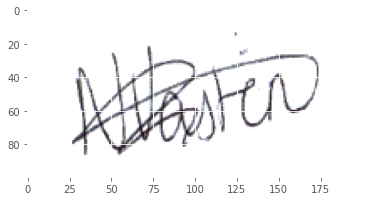

In [48]:
# Метод mypredict для идентификации подписи
def mypredict(img_path):
  img = image.load_img(img_path,target_size = target_size)
  x = image.img_to_array(img)
  x = x.reshape((1,) + x.shape)
  i = 0 
  for batch in test_datagen.flow(x,batch_size=1):
    imgplot = plt.imshow(image.array_to_img(batch[0]),cmap = 'Greys')
    print("Точность: "+str(model.predict(batch).max()))
    print("Класс: "+str(model.predict_classes(batch)))
    
    i += 1
    if i%1==0:
      break
  plt.show

from keras.preprocessing import image
import os
d = "data/val/040"
fnames = [os.path.join(d,fname) for 
          fname in os.listdir(d)] 
mypredict(fnames[1])